In [1]:
import h5py
import pandas as pd
import csv
import numpy as np

# Read csv and extract site-specific embedding
def extract_embedding(protein_id, site, h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5_file:
        if protein_id not in h5_file:
            return None  # Protein ID not found, return None
        dataset = h5_file[protein_id]
        if site-1 >= dataset.shape[0] or site <= 0:
            return None  # Site index is out of bounds, return None

        embedding = dataset[site-1]
        return embedding.flatten()

def load_site_information(input_csv_path, output_csv_path, h5_file_path):
    df = pd.read_csv(input_csv_path)
    protein_ids = df['accession'].values
    sites = df['site'].values
    count = 0
    
    with open(output_csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        # Write header if file is empty
        if f.tell() == 0:
            writer.writerow(['protein_id', 'site', 'embedding'])
        
        for (protein_id, site) in zip(protein_ids, sites):
            embedding = extract_embedding(protein_id, site, h5_file_path)
            count += 1
            if embedding is not None:
                # Convert embedding array to a space-separated string
                embedding_str = ' '.join(map(str, embedding))
                writer.writerow([protein_id, site, embedding_str])    
                print(f"{count}. {protein_id},{site}")
            else:
                print(f"{count}. Embedding not found for {protein_id} at site {site}")

if __name__ == '__main__':
    print("Loading ESM2 embeddings for train_pos dataset")
    load_site_information('data/info/positive_sites.csv',
                          'Embeddings/ESM_650/train_pos_esm650.csv', 'ESM2_650_embeddings_D2.h5')
    print("Loading ESM2 embeddings for train_neg dataset")
    load_site_information('data/info/negative_sites.csv',
                          'Embeddings/ESM_650/train_neg_esm650.csv', 'ESM2_650_embeddings_D2.h5')
    print("Loading ESM2 embeddings for test_pos dataset")
    load_site_information('data/info/test_positive_sites.csv',
                          'Embeddings/ESM_650/test_pos_esm650.csv', 'ESM2_650_embeddings_D2.h5')
    print("Loading ESM2 embeddings for test_neg dataset")
    load_site_information('data/info/test_negative_sites.csv',
                          'Embeddings/ESM_650/test_neg_esm650.csv', 'ESM2_650_embeddings_D2.h5')


Loading ESM2 embeddings for train_pos dataset
1. P0A823,227
2. P75863,344
3. P0ABS8,7
4. P0ABS8,74
5. P0A7D7,3
6. P0A7D7,52
7. P0A7D7,203
8. P0A7D7,157
9. P0A7D7,13
10. P0A7D7,163
11. P0A7D7,103
12. P0A7D7,152
13. P0A8E7,159
14. P0A8E7,90
15. P0A8E7,108
16. Q47147,50
17. Q47147,115
18. P11458,77
19. P11458,179
20. P0A7P5,11
21. P12996,103
22. P0AC92,7
23. P0AC92,53
24. P00452,584
25. P00452,723
26. P00452,727
27. P00452,9
28. P0AE63,61
29. P0AE63,37
30. P0AE63,26
31. P76108,127
32. P76108,119
33. P63235,489
34. P25524,110
35. P25524,207
36. P24228,98
37. P00961,565
38. P00961,146
39. P00961,592
40. P00961,584
41. P00961,607
42. P00961,624
43. P00961,214
44. P00961,674
45. P00961,72
46. P00961,86
47. P00961,282
48. P00961,286
49. P09394,188
50. P09394,127
51. P09394,140
52. P09394,173
53. P02359,35
54. P02359,17
55. P02359,131
56. P02359,171
57. P02359,149
58. P77754,43
59. P77754,135
60. P0A8I3,209
61. P00561,5
62. P00561,415
63. P00561,770
64. P39838,96
65. P76550,209
66. P76550,117
6

KeyboardInterrupt: 

In [3]:
from sklearn.model_selection import train_test_split
#Read csv 
train_pos = pd.read_csv('Embeddings/Prot_t5/train_pos_t5.csv')
train_neg = pd.read_csv('Embeddings/Prot_t5/train_neg_t5.csv')
test_pos = pd.read_csv('Embeddings/Prot_t5/test_pos_t5.csv')
test_neg = pd.read_csv('Embeddings/Prot_t5/test_neg_t5.csv')

#Concatenate positive and negative datasets and add labels
train_pos['label'] = 1
train_neg['label'] = 0
train = pd.concat([train_pos, train_neg])
test_pos['label'] = 1
test_neg['label'] = 0
test = pd.concat([test_pos, test_neg])

print(train.shape)
print(test.shape)

from Bio import SeqIO

# For protein_id and site, get the sequence from the FASTA file
def get_sequence(protein_id, site, fasta_file, window_size=32, pad_char='-'):
    with open(fasta_file) as fasta:
        for record in SeqIO.parse(fasta, 'fasta'):
            if record.id == protein_id:
                seq = record.seq
                site = int(site)

                # Calculate start and end indices
                start = max(0, site - window_size - 1)
                end = min(len(seq), site + window_size)

                # Extract the sequence
                extracted_seq = str(seq[start:end])

                # Calculate padding needed on the left and right
                left_padding = max(0, window_size - site +1)
                right_padding = max(0, (site + window_size) - len(seq))

                # Add padding if necessary
                padded_seq = (pad_char * left_padding) + extracted_seq + (pad_char * right_padding)

                return padded_seq
    return None


# Get sequence for train and test datasets and add to dataframe
train['sequence'] = train.apply(lambda x: get_sequence(x['protein_id'], x['site'], 'data/full_sequences/all_sequence_cleaned.fasta'), axis=1)
test['sequence'] = test.apply(lambda x: get_sequence(x['protein_id'], x['site'], 'data/full_sequences/all_sequence_cleaned.fasta'), axis=1)

amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'

# Drop rows with amino acids not in the list
train = train[train['sequence'].apply(lambda x: all(aa in amino_acids for aa in x))]
test = test[test['sequence'].apply(lambda x: all(aa in amino_acids for aa in x))]

train, val = train_test_split(train, test_size=0.1, random_state=42)

# Write train and test datasets to CSV
train.to_csv('Embeddings/D1/train_D1_65.csv', index=False)
val.to_csv('Embeddings/D1/val_D1_65.csv', index=False)
test.to_csv('Embeddings/D1/test_D1_65.csv', index=False)


(9347, 4)
(3226, 4)


Import Libraries:

In [2]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


Load Data:

In [3]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')


print(train.shape)
print(val.shape)
print(test.shape)

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(935, 1024)
(3226, 1024)
(8411, 20)
(935, 20)
(3226, 20)
(8411, 33)
(935, 33)
(3226, 33)
(8411,)
(935,)
(3226,)


In [4]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [5]:
def plot_roc_pr (title, y_true, y_prob, aucs, auprcs):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % np.mean(aucs))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(title+'_roc.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, color='green', label='PR curve (AUPRC = %0.2f)' % np.mean(auprcs))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(title+'_PR.pdf', format='pdf', bbox_inches='tight')

    plt.show()
    

In [6]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

Simple Model:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 21)    │      1,344 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 33, 32)    │      2,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 16, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 16, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 8, 64)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     16,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     32,800 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,929 (238.00 KB)

 Trainable params: 60,929 (238.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5132 - loss: 0.6962 - val_accuracy: 0.6182 - val_loss: 0.6803
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5798 - loss: 0.6779 - val_accuracy: 0.6578 - val_loss: 0.6626
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6208 - loss: 0.6639 - val_accuracy: 0.6631 - val_loss: 0.6391
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6415 - loss: 0.6457 - val_accuracy: 0.6824 - val_loss: 0.6143
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6601 - loss: 0.6259 - val_accuracy: 0.6973 - val_loss: 0.5946
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.6083 - val_accuracy: 0.7134 - val_loss: 0.5785
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6842 - loss: 0.6018 - val_accuracy: 0.7198 - val_loss: 0.5663
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7021 - loss: 0.5846 - val_accuracy: 0.

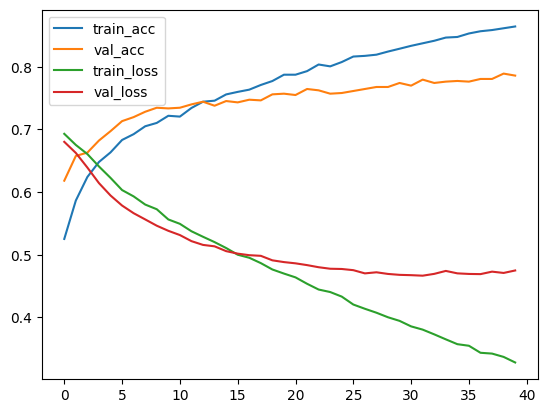

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7861
MCC: 0.5713
AUC: 0.7859
AUPRC: 0.8459
Precision: 0.8025
Recall: 0.7895
Specificity: 0.7823
F1 Score: 0.7959
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7852
MCC: 0.3309
AUC: 0.7677
AUPRC: 0.3088
Precision: 0.2311
Recall: 0.7470
Specificity: 0.7884
F1 Score: 0.3529


(0.7851828890266584,
 0.3308900621321118,
 0.7677323846103734,
 0.30880213571154336,
 0.2310513447432763,
 0.7470355731225297,
 0.7884291960982173,
 0.35294117647058826)

In [7]:
def build_simple_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)
    x_conv = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model




set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_model = build_simple_model((33,), 1024)
simple_model.summary()

# Fit the Inception model
history = simple_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(simple_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val=y_val)
evaluate_model(simple_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val=y_test)

Inception Model:

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 21)    │      1,344 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 33, 21)    │          0 │ embedding_1[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 33, 32)    │        704 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 33, 32)    │      2,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 33, 32)    │      3,392 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 33, 32)    │      4,736 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 33, 32)    │      6,080 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 33, 32)    │        704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33, 192)   │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 16, 192)   │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3072)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │     98,336 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │     32,800 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 152,257 (594.75 KB)

 Trainable params: 152,257 (594.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5160 - loss: 0.6962 - val_accuracy: 0.6353 - val_loss: 0.6730
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5974 - loss: 0.6727 - val_accuracy: 0.6620 - val_loss: 0.6474
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6243 - loss: 0.6504 - val_accuracy: 0.7027 - val_loss: 0.6159
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6513 - loss: 0.6283 - val_accuracy: 0.7123 - val_loss: 0.5900
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6835 - loss: 0.6072 - val_accuracy: 0.7305 - val_loss: 0.5581
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6918 - loss: 0.5835 - val_accuracy: 0.7433 - val_loss: 0.5357
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7231 - loss: 0.5628 - val_accuracy: 0.7465 - val_loss: 0.5242
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7286 - loss: 0.5492 - val_accuracy: 0.

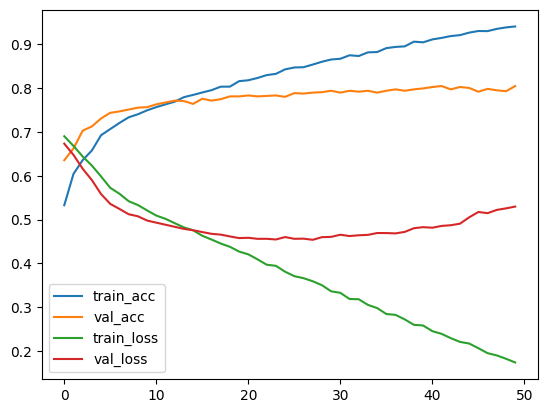

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8043
MCC: 0.6075
AUC: 0.8038
AUPRC: 0.8529
Precision: 0.8167
Recall: 0.8117
Specificity: 0.7959
F1 Score: 0.8142
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7712
MCC: 0.3278
AUC: 0.7710
AUPRC: 0.2994
Precision: 0.2229
Recall: 0.7708
Specificity: 0.7713
F1 Score: 0.3457


(0.7712337259764415,
 0.32775349312543545,
 0.7710128973674799,
 0.29935556000345254,
 0.22285714285714286,
 0.7707509881422925,
 0.7712748065926673,
 0.34574468085106386)

In [8]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 9
    branch5 = Conv1D(32, kernel_size=9, activation='relu', padding='same')(input_tensor)

    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch6 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch6)


    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5, branch6])
    return output

def build_inception_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_model = build_inception_model((33,), 1024)
inception_model.summary()


# Fit the Inception model
history = inception_model.fit([X_train_num, X_train_embeddings], y_train, epochs=50, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(inception_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)
evaluate_model(inception_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)


Residual Connections Model :

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 21)    │        441 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 33, 32)    │      2,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 33, 32)    │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33, 53)    │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 16, 53)    │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 16, 64)    │     10,240 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 16, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 117)   │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 8, 117)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 936)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     29,984 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     32,800 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,082 (363.60 KB)

 Trainable params: 93,082 (363.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5029 - loss: 0.6953 - val_accuracy: 0.5561 - val_loss: 0.6884
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5563 - loss: 0.6848 - val_accuracy: 0.5872 - val_loss: 0.6765
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5882 - loss: 0.6743 - val_accuracy: 0.6278 - val_loss: 0.6557
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6309 - loss: 0.6527 - val_accuracy: 0.6567 - val_loss: 0.6267
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6532 - loss: 0.6310 - val_accuracy: 0.6877 - val_loss: 0.6016
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6725 - loss: 0.6110 - val_accuracy: 0.7059 - val_loss: 0.5766
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6882 - loss: 0.5887 - val_accuracy: 0.7251 - val_loss: 0.5452
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7133 - loss: 0.5667 - val_accuracy: 0.

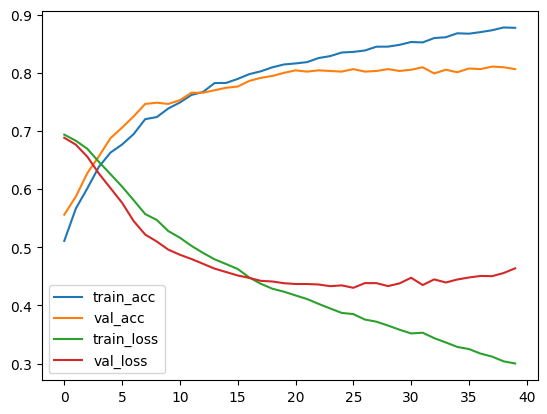

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8064
MCC: 0.6144
AUC: 0.8077
AUPRC: 0.8579
Precision: 0.8380
Recall: 0.7854
Specificity: 0.8299
F1 Score: 0.8109
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8258
MCC: 0.3786
AUC: 0.7880
AUPRC: 0.3304
Precision: 0.2745
Recall: 0.7431
Specificity: 0.8328
F1 Score: 0.4009


(0.8257904525728457,
 0.37858732621667374,
 0.7879558982090462,
 0.3304048196904134,
 0.27445255474452557,
 0.7430830039525692,
 0.832828792465523,
 0.40085287846481876)

In [7]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (ResNet) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
res_model = build_resnet_model((33,), 1024)
res_model.summary()

# Fit the Inception model
history = res_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(res_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)
evaluate_model(res_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)


Simple + PSSM model:

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 33, 21)    │      1,344 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 16, 32)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 16, 64)    │      6,208 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 8, 64)     │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 512)       │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │     16,416 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │     32,800 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │        336 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 80)        │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ dropout_10[0][0], │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,592 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32)        │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         33 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 61,777 (241.32 KB)

 Trainable params: 61,777 (241.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5035 - loss: 0.7096 - val_accuracy: 0.5326 - val_loss: 0.6892
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5352 - loss: 0.6937 - val_accuracy: 0.5818 - val_loss: 0.6755
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5588 - loss: 0.6845 - val_accuracy: 0.6385 - val_loss: 0.6597
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5884 - loss: 0.6676 - val_accuracy: 0.6567 - val_loss: 0.6405
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6212 - loss: 0.6534 - val_accuracy: 0.6888 - val_loss: 0.6200
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6385 - loss: 0.6332 - val_accuracy: 0.7048 - val_loss: 0.6022
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6599 - loss: 0.6185 - val_accuracy: 0.7112 - val_loss: 0.5871
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6739 - loss: 0.6093 - val_accuracy: 0.

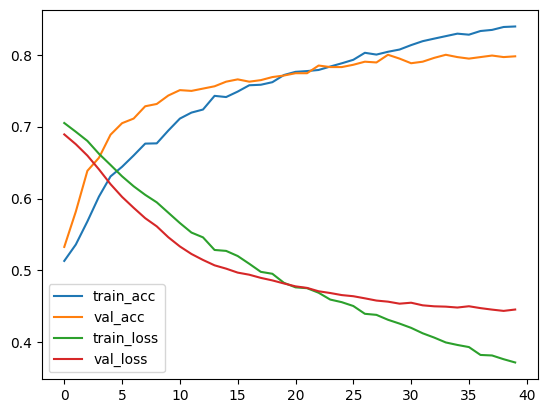

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7979
MCC: 0.5941
AUC: 0.7956
AUPRC: 0.8599
Precision: 0.7927
Recall: 0.8360
Specificity: 0.7551
F1 Score: 0.8138
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7740
MCC: 0.3365
AUC: 0.7780
AUPRC: 0.3222
Precision: 0.2271
Recall: 0.7826
Specificity: 0.7733
F1 Score: 0.3520


(0.7740235585864849,
 0.33650708989397815,
 0.7779508328580412,
 0.32217738107437316,
 0.22706422018348624,
 0.782608695652174,
 0.7732929700639085,
 0.352)

In [10]:
def build_simple_pssm_model(input_shape_conv, input_shape_ann, input_shape_pssm):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)
    x_conv = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # PSSM branch
    pssm_input = Input(shape=(input_shape_pssm,))
    x_pssm = Dense(16, activation='relu')(pssm_input)
    x_pssm = Dropout(0.3)(x_pssm)

    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann, x_pssm])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input, pssm_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model




set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_pssm_model = build_simple_pssm_model((33,), 1024, 20)
simple_pssm_model.summary()

# Fit the Inception model
history = simple_pssm_model.fit([X_train_num, X_train_embeddings, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=1,
                                 validation_data=([X_val_num, X_val_embeddings, X_val_PSSM], y_val),
                            )

plot(history)

evaluate_model(simple_pssm_model, X_val_num, X_val_embeddings, X_val_PSSM, y_val)
evaluate_model(simple_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)

Inception+PSSM model:

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 33, 21)    │      1,344 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 33, 21)    │          0 │ embedding_4[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 33, 32)    │        704 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 33, 32)    │      3,392 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 33, 32)    │      4,736 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 33, 32)    │      6,080 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 33, 32)    │        704 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 33, 192)   │          0 │ conv1d_14[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_15[0][0],  │
│                     │                   │            │ conv1d_16[0][0],  │
│                     │                   │            │ conv1d_17[0][0],  │
│                     │                   │            │ conv1d_18[0][0],  │
│                     │                   │            │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 16, 192)   │          0 │ concatenate_7[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3072)      │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │     98,336 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │     32,800 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        336 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ dense_18[0][0]  

 Total params: 153,105 (598.07 KB)

 Trainable params: 153,105 (598.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4890 - loss: 0.7267 - val_accuracy: 0.5080 - val_loss: 0.6932
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5192 - loss: 0.6984 - val_accuracy: 0.5604 - val_loss: 0.6803
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5705 - loss: 0.6815 - val_accuracy: 0.6321 - val_loss: 0.6586
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6116 - loss: 0.6554 - val_accuracy: 0.6706 - val_loss: 0.6313
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6345 - loss: 0.6373 - val_accuracy: 0.7059 - val_loss: 0.6035
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6617 - loss: 0.6184 - val_accuracy: 0.7070 - val_loss: 0.5805
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6854 - loss: 0.5928 - val_accuracy: 0.7219 - val_loss: 0.5568
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7064 - loss: 0.5744 - val_accuracy: 0.

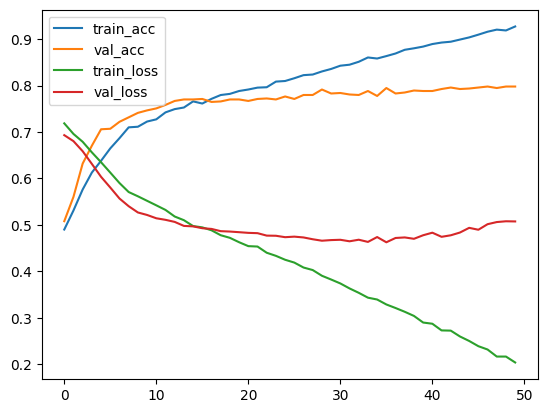

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7979
MCC: 0.5942
AUC: 0.7969
AUPRC: 0.8633
Precision: 0.8056
Recall: 0.8138
Specificity: 0.7800
F1 Score: 0.8097
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7725
MCC: 0.3368
AUC: 0.7789
AUPRC: 0.2742
Precision: 0.2264
Recall: 0.7866
Specificity: 0.7713
F1 Score: 0.3516


(0.7724736515809052,
 0.3368319864447801,
 0.7789180357074008,
 0.27420950411528555,
 0.22639362912400454,
 0.7865612648221344,
 0.7712748065926673,
 0.35159010600706714)

In [11]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 9
    branch5 = Conv1D(32, kernel_size=9, activation='relu', padding='same')(input_tensor)

    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch6 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch6)


    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5, branch6])
    return output

def build_inception_pssm_model(input_shape_conv, input_shape_ann, input_shape_pssm):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # PSSM branch
    pssm_input = Input(shape=(input_shape_pssm,))

    # Simple Dense layer for PSSM features
    x_pssm = Dense(16, activation='relu')(pssm_input)
    x_pssm = Dropout(0.3)(x_pssm)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann, x_pssm])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input, pssm_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_pssm_model = build_inception_pssm_model((33,), 1024, 20)
inception_pssm_model.summary()


# Fit the Inception model
history = inception_pssm_model.fit([X_train_num, X_train_embeddings, X_train_PSSM], y_train, epochs=50, batch_size=64, verbose=1,
                                 validation_data=([X_val_num, X_val_embeddings, X_val_PSSM], y_val),
                             )

plot(history)

evaluate_model(inception_pssm_model, X_val_num, X_val_embeddings, X_val_PSSM= X_val_PSSM, y_val = y_val)
evaluate_model(inception_pssm_model, X_test_num, X_test_embeddings, X_val_PSSM= X_test_PSSM, y_val = y_test)


Resnet+PSSM model:

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 33, 21)    │        441 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 33, 32)    │      3,104 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 33, 53)    │          0 │ conv1d_21[0][0],  │
│ (Concatenate)       │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 16, 53)    │          0 │ concatenate_9[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 16, 64)    │     10,240 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 16, 64)    │     12,352 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 16, 117)   │          0 │ conv1d_23[0][0],  │
│ (Concatenate)       │                   │            │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 8, 117)    │          0 │ concatenate_10[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 936)       │          0 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │     29,984 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │     32,800 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │        336 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 16)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 93,930 (366.91 KB)

 Trainable params: 93,930 (366.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5049 - loss: 0.7266 - val_accuracy: 0.5947 - val_loss: 0.6755
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5492 - loss: 0.6911 - val_accuracy: 0.6203 - val_loss: 0.6583
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5726 - loss: 0.6747 - val_accuracy: 0.6588 - val_loss: 0.6375
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6179 - loss: 0.6550 - val_accuracy: 0.6813 - val_loss: 0.6157
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6460 - loss: 0.6321 - val_accuracy: 0.7230 - val_loss: 0.5948
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6701 - loss: 0.6148 - val_accuracy: 0.7241 - val_loss: 0.5733
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6839 - loss: 0.6025 - val_accuracy: 0.7412 - val_loss: 0.5478
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7031 - loss: 0.5768 - val_accuracy: 0.

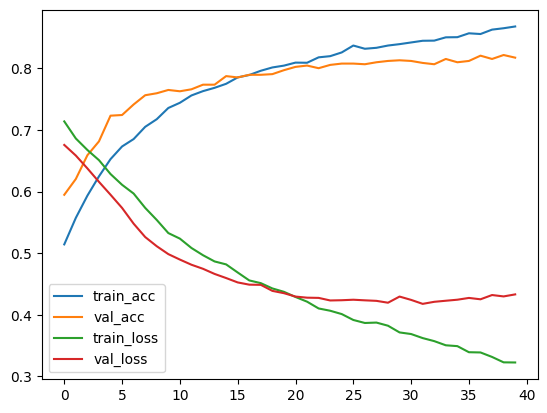

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.8171
MCC: 0.6340
AUC: 0.8174
AUPRC: 0.8652
Precision: 0.8372
Recall: 0.8117
Specificity: 0.8231
F1 Score: 0.8243
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8075
MCC: 0.3842
AUC: 0.8052
AUPRC: 0.3293
Precision: 0.2623
Recall: 0.8024
Specificity: 0.8079
F1 Score: 0.3953


(0.8075015499070056,
 0.38421758655046373,
 0.8051548255777625,
 0.32928554225497003,
 0.2622739018087855,
 0.8023715415019763,
 0.8079381096535486,
 0.3953261927945472)

In [12]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_pssm_model(input_shape_conv, input_shape_ann, input_shape_pssm):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    pssm_input = Input(shape=(input_shape_pssm,))

    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # PSSM branch
    x_pssm = Dense(16, activation='relu')(pssm_input)
    x_pssm = Dropout(0.3)(x_pssm)

    # Concatenate Conv1D (ResNet), ANN, and PSSM branches
    combined = Concatenate()([x_conv, x_ann, x_pssm])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input, pssm_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,), ANN input shape 1024, and PSSM input shape 20
res_pssm_model = build_resnet_pssm_model((33,), 1024, 20)
res_pssm_model.summary()

# Fit the model with PSSM included
history = res_pssm_model.fit([X_train_num, X_train_embeddings, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings, X_val_PSSM], y_val),
                            )

plot(history)

evaluate_model(res_pssm_model, X_val_num, X_val_embeddings, X_val_PSSM, y_val)
evaluate_model(res_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)


Save and Load the models :

In [65]:
simple_model.save('Thesis-Results/Models/Full Models/simple_model.h5')
inception_model.save('Thesis-Results/Models/Full Models/inception_model.h5')
res_model.save('Thesis-Results/Models/Full Models/res_model.h5')
simple_pssm_model.save('Thesis-Results/Models/Full Models/simple_pssm_model.h5')
inception_pssm_model.save('Thesis-Results/Models/Full Models/inception_pssm_model.h5')
res_pssm_model.save('Thesis-Results/Models/Full Models/res_pssm_model.h5')

simple_model.save_weights('Thesis-Results/Models/Weights/simple_model.weights.h5')
inception_model.save_weights('Thesis-Results/Models/Weights/inception_model.weights.h5')
res_model.save_weights('Thesis-Results/Models/Weights/res_model.weights.h5')
simple_pssm_model.save_weights('Thesis-Results/Models/Weights/simple_pssm_model.weights.h5')
inception_pssm_model.save_weights('Thesis-Results/Models/Weights/inception_pssm_model.weights.h5')
res_pssm_model.save_weights('Thesis-Results/Models/Weights/res_pssm_model.weights.h5')

In [67]:
#Load the models and evaluate them
from keras.models import load_model

simple_model = build_simple_model((33,), 1024)
simple_model.load_weights('Thesis-Results/Models/Weights/simple_model.weights.h5')

inception_model = build_inception_model((33,), 1024)
inception_model.load_weights('Thesis-Results/Models/Weights/inception_model.weights.h5')

res_model = build_resnet_model((33,), 1024)
res_model.load_weights('Thesis-Results/Models/Weights/res_model.weights.h5')

simple_pssm_model = build_simple_pssm_model((33,), 1024, 20)
simple_pssm_model.load_weights('Thesis-Results/Models/Weights/simple_pssm_model.weights.h5')

inception_pssm_model = build_inception_pssm_model((33,), 1024, 20)
inception_pssm_model.load_weights('Thesis-Results/Models/Weights/inception_pssm_model.weights.h5')

res_pssm_model = build_resnet_pssm_model((33,), 1024, 20)
res_pssm_model.load_weights('Thesis-Results/Models/Weights/res_pssm_model.weights.h5')

print("Simple Model:")
evaluate_model(simple_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)
print("Inception Model:")
evaluate_model(inception_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)
print("Residual Model:")
evaluate_model(res_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)
print("Simple Model with PSSM:")
evaluate_model(simple_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)
print("Inception Model with PSSM:")
evaluate_model(inception_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)
print("Residual Model with PSSM:")
evaluate_model(res_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 varia

Simple Model:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7852
MCC: 0.3309
AUC: 0.7677
AUPRC: 0.3088
Precision: 0.2311
Recall: 0.7470
Specificity: 0.7884
F1 Score: 0.3529
Inception Model:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7712
MCC: 0.3278
AUC: 0.7710
AUPRC: 0.2994
Precision: 0.2229
Recall: 0.7708
Specificity: 0.7713
F1 Score: 0.3457
Residual Model:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8258
MCC: 0.3786
AUC: 0.7880
AUPRC: 0.3304
Precision: 0.2745
Recall: 0.7431
Specificity: 0.8328
F1 Score: 0.4009
Simple Model with PSSM:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7740
MCC: 0.3365
AUC: 0.7780
AUPRC: 0.3222
Precision: 0.2271
Recall: 0.7826
Specificity: 0.7733
F1 Score: 0.3520
Inception Model with PSSM:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7725
MCC: 0.3368
AUC: 0.7789
AUPRC: 0.2742
Precision: 0.2264
Recall: 0.7866
Specificity: 0.7713
F1 Score: 0.3516
Residual Model with PSSM:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accur

(0.8075015499070056,
 0.38421758655046373,
 0.8051548255777625,
 0.32928554225497003,
 0.2622739018087855,
 0.8023715415019763,
 0.8079381096535486,
 0.3953261927945472)

Croos Validation:

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7989
MCC: 0.6013
AUC: 0.7953
AUPRC: 0.8587
Precision: 0.7688
Recall: 0.8791
Specificity: 0.7114
F1 Score: 0.8203
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8171
MCC: 0.6425
AUC: 0.8191
AUPRC: 0.8797
Precision: 0.7706
Recall: 0.8877
Specificity: 0.7505
F1 Score: 0.8250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7957
MCC: 0.5914
AUC: 0.7951
AUPRC: 0.8709
Precision: 0.8050
Recall: 0.7681
Specificity: 0.8222
F1 Score: 0.7861
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8053
MCC: 0.6110
AUC: 0.8055
AUPRC: 0.8437
Precision: 0.7958
Recall: 0.8164
Specificity: 0.7945
F1 Score: 0.8060
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8064
MCC: 0.6130
AUC: 0.8064
AUPRC: 0.8416
Precision: 0.7996
Recall: 0.8184
Specificity: 0.7944
F1

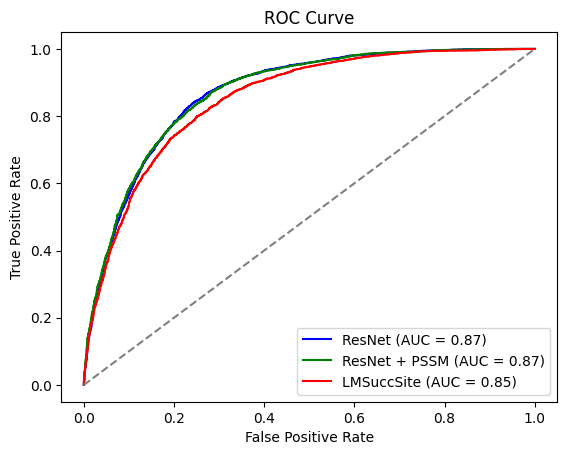

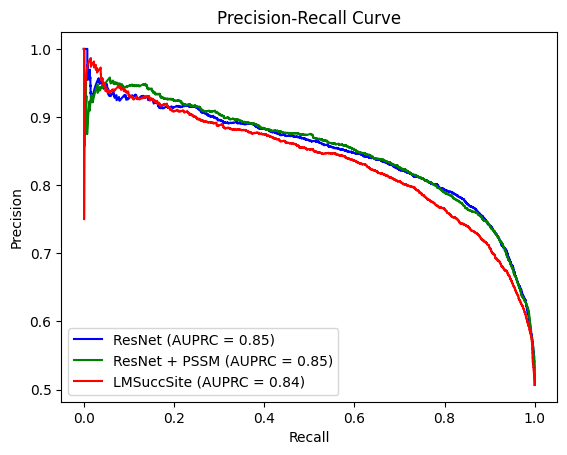

In [23]:
#croos validation
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, random_state=4, shuffle=True)


# Perform cross-validation in a function
def cross_validate_model(model_name, X, X_pt5, y, kf, X_PSSM = None):
    set_seed(4)

    # Initialize lists to store the results
    y_preds = []
    y_trues = []
    y_probs = []

    accuracies = []
    mccs = []
    aucs = []
    auprcs = []
    precisions = []
    recalls = []
    specificities = []
    f1s = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        X_train_pt5, X_val_pt5 = X_pt5[train_index], X_pt5[val_index]
        y_train, y_val = y[train_index], y[val_index]
        if X_PSSM is not None:
            X_train_PSSM, X_val_PSSM = X_PSSM[train_index], X_PSSM[val_index]

        # reinitialize the model
        if model_name == 'inception_model':
            model = build_inception_model((33,), 1024)
        elif model_name == 'res_model':
            model = build_resnet_model((33,), 1024)
        elif model_name == 'simple_model':
            model = build_simple_model((33,), 1024)
        elif model_name == 'simple_pssm_model':
            model = build_simple_pssm_model((33,), 1024, 20)
        elif model_name == 'inception_pssm_model':
            model = build_inception_pssm_model((33,), 1024, 20)
        elif model_name == 'res_pssm_model':
            model = build_resnet_pssm_model((33,), 1024, 20)

        # Fit the model
        if X_PSSM is None:
            history = model.fit([X_train, X_train_pt5], y_train, epochs=40, batch_size=64, verbose=0,
                                validation_data=([X_val, X_val_pt5], y_val))
        else:
            history = model.fit([X_train, X_train_pt5, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=0,
                                validation_data=([X_val, X_val_pt5, X_val_PSSM], y_val))
                    
        y_true = y_val
        # Predict probabilities
        if X_PSSM is None:
            y_pred_probs = model.predict([X_val, X_val_pt5])
        else:
            y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

        # Convert probabilities to binary predictions
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Append the results to the lists
        y_preds.append(y_pred)
        y_trues.append(y_true)
        y_probs.append(y_pred_probs)

        # Evaluate the model
        if X_PSSM is None:
            accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5,
                                                                                            X_val_PSSM=None, y_val=y_val, print_metrics=True)
        else:
            accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5,
                                                                                            X_val_PSSM, y_val, print_metrics=True)
        # Append the results to the lists
        accuracies.append(accuracy)
        mccs.append(mcc)
        aucs.append(auc)
        auprcs.append(auprc)
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        f1s.append(f1)
    # Print the average results +- standard deviation
    print(f"Results for {model_name}:")
    print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
    print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
    print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
    print(f'AUPRC: {np.mean(auprcs)} +- {np.std(auprcs)}')
    print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
    print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
    print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
    print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')

    # plot_roc_pr(model_name, np.concatenate(y_trues), np.concatenate(y_probs), aucs, auprcs)

    return np.concatenate(y_trues), np.concatenate(y_probs), aucs, auprcs

X_train_num = np.concatenate([X_train_num, X_val_num])
X_train_embeddings = np.concatenate([X_train_embeddings, X_val_embeddings])
X_train_PSSM = np.concatenate([X_train_PSSM, X_val_PSSM])
y_train = np.concatenate([y_train, y_val])

# Perform cross-validation for the 6 models
# cross_validate_model('simple_model', X_train_num, X_train_embeddings, y_train, kf)
# cross_validate_model('inception_model', X_train_num, X_train_embeddings, y_train, kf)
res_y_trues, res_y_probs, res_aucs, res_auprcs = cross_validate_model('res_model', X_train_num, X_train_embeddings, y_train, kf)
# cross_validate_model('simple_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)
# cross_validate_model('inception_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)
res_pssm_y_trues, res_pssm_y_probs, res_pssm_aucs, res_pssm_auprcs = cross_validate_model('res_pssm_model', 
                                                                                          X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)

LM_y_true_all = np.load('Thesis-Results/LM_y_true_all.npy')
LM_y_pred_all = np.load('Thesis-Results/LM_y_pred_all.npy')
LM_y_pred_proba_all = np.load('Thesis-Results/LM_y_pred_proba_all.npy')

# Plot ROC and PR curves for all models in a single plot
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

fpr_res, tpr_res, _ = roc_curve(res_y_trues, res_y_probs)
fpr_res_pssm, tpr_res_pssm, _ = roc_curve(res_pssm_y_trues, res_pssm_y_probs)
fpr_lm, tpr_lm, _ = roc_curve(LM_y_true_all, LM_y_pred_proba_all)
plt.figure()
plt.plot(fpr_res, tpr_res, color='blue', label='ResNet (AUC = %0.2f)' % roc_auc_score(res_y_trues, res_y_probs))
plt.plot(fpr_res_pssm, tpr_res_pssm, color='green', label='ResNet + PSSM (AUC = %0.2f)' % roc_auc_score(res_pssm_y_trues, res_pssm_y_probs))
plt.plot(fpr_lm, tpr_lm, color='red', label='LMSuccSite (AUC = %0.2f)' % roc_auc_score(LM_y_true_all, LM_y_pred_proba_all))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

precision_res, recall_res, _ = precision_recall_curve(res_y_trues, res_y_probs)
precision_res_pssm, recall_res_pssm, _ = precision_recall_curve(res_pssm_y_trues, res_pssm_y_probs)
precision_lm, recall_lm, _ = precision_recall_curve(LM_y_true_all, LM_y_pred_proba_all)
plt.figure()
plt.plot(recall_res, precision_res, color='blue', label='ResNet (AUPRC = %0.2f)' % average_precision_score(res_y_trues, res_y_probs))
plt.plot(recall_res_pssm, precision_res_pssm, color='green', label='ResNet + PSSM (AUPRC = %0.2f)' % average_precision_score(res_pssm_y_trues, res_pssm_y_probs))
plt.plot(recall_lm, precision_lm, color='red', label='LMSuccSite (AUPRC = %0.2f)' % average_precision_score(LM_y_true_all, LM_y_pred_proba_all))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('PR_curve.pdf', format='pdf', bbox_inches='tight')

plt.show()



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7914
MCC: 0.5818
AUC: 0.7901
AUPRC: 0.8554
Precision: 0.7890
Recall: 0.8197
Specificity: 0.7606
F1 Score: 0.8040
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7829
MCC: 0.5687
AUC: 0.7840
AUPRC: 0.8447
Precision: 0.7535
Recall: 0.8216
Specificity: 0.7464
F1 Score: 0.7861
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7583
MCC: 0.5168
AUC: 0.7585
AUPRC: 0.8311
Precision: 0.7463
Recall: 0.7659
Specificity: 0.7510
F1 Score: 0.7559
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7829
MCC: 0.5657
AUC: 0.7828
AUPRC: 0.8357
Precision: 0.7826
Recall: 0.7775
Specificity: 0.7881
F1 Score: 0.7801
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7647
MCC: 0.5297
AUC: 0.7647
AUPRC: 0.8207
Precision: 0.7562
Recall: 0.7821
Specificity: 0.74

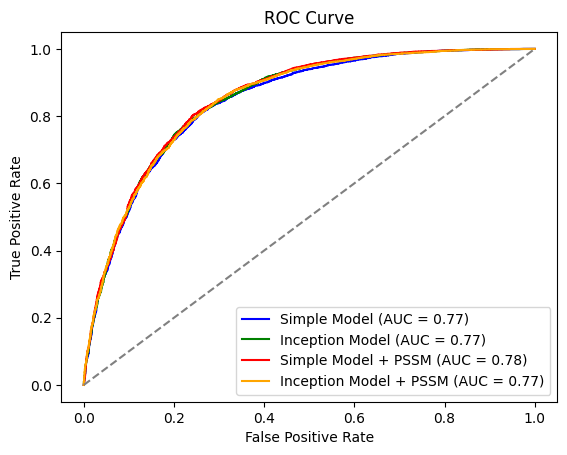

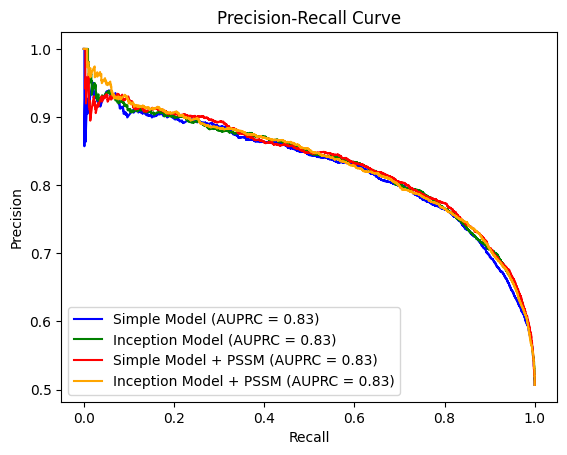

In [24]:
simple_y_true, simple_y_pred, simple_aucs, simple_auprcs = cross_validate_model('simple_model', X_train_num, X_train_embeddings, y_train, kf)
incept_y_true, incept_y_pred, incept_aucs, incept_auprcs = cross_validate_model('inception_model', X_train_num, X_train_embeddings, y_train, kf)
simple_pssm_y_true, simple_pssm_y_pred, simple_pssm_aucs, simple_pssm_auprcs = cross_validate_model('simple_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)
incept_pssm_y_true, incept_pssm_y_pred, incept_pssm_aucs, incept_pssm_auprcs = cross_validate_model('inception_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)



# Plot ROC and PR curves for all models in a single plot
fpr_simple, tpr_simple, _ = roc_curve(simple_y_true, simple_y_pred)
fpr_incept, tpr_incept, _ = roc_curve(incept_y_true, incept_y_pred)
fpr_simple_pssm, tpr_simple_pssm, _ = roc_curve(simple_pssm_y_true, simple_pssm_y_pred)
fpr_incept_pssm, tpr_incept_pssm, _ = roc_curve(incept_pssm_y_true, incept_pssm_y_pred)
plt.figure()
plt.plot(fpr_simple, tpr_simple, color='blue', label='Simple Model (AUC = %0.2f)' % np.mean(simple_aucs))
plt.plot(fpr_incept, tpr_incept, color='green', label='Inception Model (AUC = %0.2f)' % np.mean(incept_aucs))
plt.plot(fpr_simple_pssm, tpr_simple_pssm, color='red', label='Simple Model + PSSM (AUC = %0.2f)' % np.mean(simple_pssm_aucs))
plt.plot(fpr_incept_pssm, tpr_incept_pssm, color='orange', label='Inception Model + PSSM (AUC = %0.2f)' % np.mean(incept_pssm_aucs))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('10_fold_CV_ROC_curve_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

precision_simple, recall_simple, _ = precision_recall_curve(simple_y_true, simple_y_pred)
precision_incept, recall_incept, _ = precision_recall_curve(incept_y_true, incept_y_pred)
precision_simple_pssm, recall_simple_pssm, _ = precision_recall_curve(simple_pssm_y_true, simple_pssm_y_pred)
precision_incept_pssm, recall_incept_pssm, _ = precision_recall_curve(incept_pssm_y_true, incept_pssm_y_pred)
plt.figure()
plt.plot(recall_simple, precision_simple, color='blue', label='Simple Model (AUPRC = %0.2f)' % np.mean(simple_auprcs))
plt.plot(recall_incept, precision_incept, color='green', label='Inception Model (AUPRC = %0.2f)' % np.mean(incept_auprcs))
plt.plot(recall_simple_pssm, precision_simple_pssm, color='red', label='Simple Model + PSSM (AUPRC = %0.2f)' % np.mean(simple_pssm_auprcs))
plt.plot(recall_incept_pssm, precision_incept_pssm, color='orange', label='Inception Model + PSSM (AUPRC = %0.2f)' % np.mean(incept_pssm_auprcs))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('10_fold_CV_PR_curve_2.pdf', format='pdf', bbox_inches='tight')

test set comparison :

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


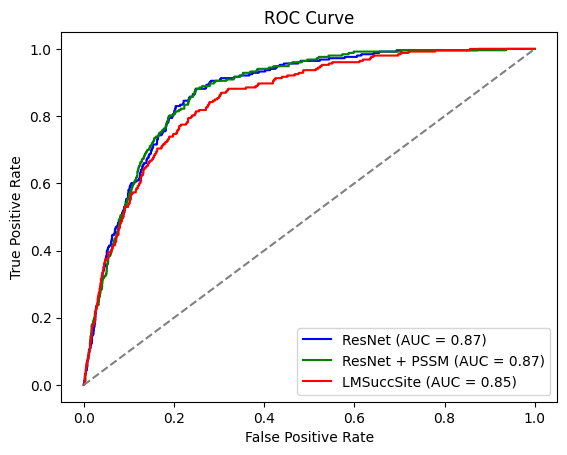

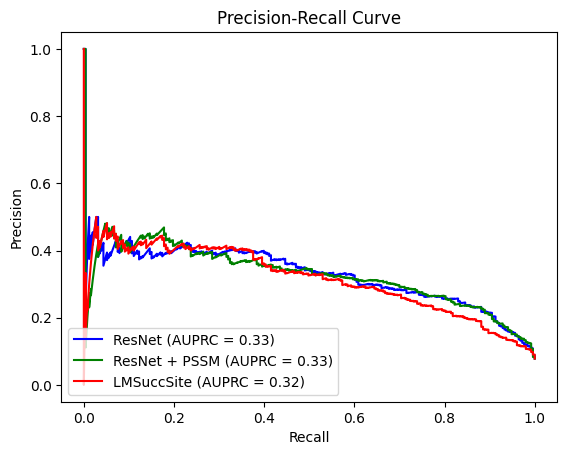

In [26]:
from keras.models import load_model

res_model = load_model('Thesis-Results/Models/Full Models/res_model.h5')
res_pssm_model = load_model('Thesis-Results/Models/Full Models/res_pssm_model.h5')

y_prob_res = res_model.predict([X_test_num, X_test_embeddings])
y_pred_res = (y_prob_res > 0.5).astype(int)

y_prob_res_pssm = res_pssm_model.predict([X_test_num, X_test_embeddings, X_test_PSSM])
y_pred_res_pssm = (y_prob_res_pssm > 0.5).astype(int)

y_prob_LM = np.load('Thesis-Results/LM_y_prob.npy')
y_pred_LM = (y_prob_LM > 0.5).astype(int)

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr_res, tpr_res, _ = roc_curve(y_test, y_prob_res)
fpr_res_pssm, tpr_res_pssm, _ = roc_curve(y_test, y_prob_res_pssm)
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_prob_LM)
plt.figure()
plt.plot(fpr_res, tpr_res, color='blue', label='ResNet (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_res))
plt.plot(fpr_res_pssm, tpr_res_pssm, color='green', label='ResNet + PSSM (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_res_pssm))
plt.plot(fpr_lm, tpr_lm, color='red', label='LMSuccSite (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_LM))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_test_set.pdf', format='pdf', bbox_inches='tight')
plt.show()

precision_res, recall_res, _ = precision_recall_curve(y_test, y_prob_res)
precision_res_pssm, recall_res_pssm, _ = precision_recall_curve(y_test, y_prob_res_pssm)
precision_lm, recall_lm, _ = precision_recall_curve(y_test, y_prob_LM)
plt.figure()
plt.plot(recall_res, precision_res, color='blue', label='ResNet (AUPRC = %0.2f)' % average_precision_score(y_test, y_prob_res))
plt.plot(recall_res_pssm, precision_res_pssm, color='green', label='ResNet + PSSM (AUPRC = %0.2f)' % average_precision_score(y_test, y_prob_res_pssm))
plt.plot(recall_lm, precision_lm, color='red', label='LMSuccSite (AUPRC = %0.2f)' % average_precision_score(y_test, y_prob_LM))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('PR_curve_test_set.pdf', format='pdf', bbox_inches='tight')
plt.show()

t-SNE plots :

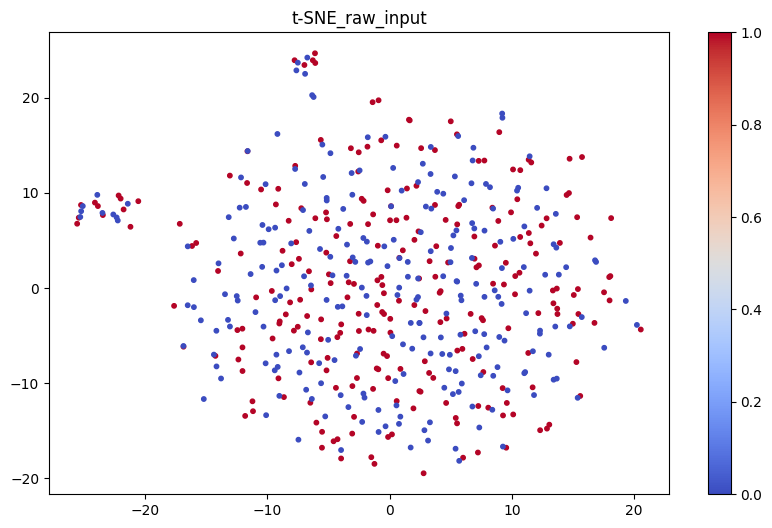

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_tsne(X, y, title):
    tsne = TSNE(n_components=2, random_state=4)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', s=10)
    plt.colorbar()
    plt.title(title)
    plt.savefig(title+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    

# Concatenate inputs for t-SNE before training
X_concat = np.concatenate([X_test_num, X_test_embeddings], axis=1)

# Plot t-SNE for the raw input features
plot_tsne(X_concat, y_test, 't-SNE_raw_input')


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


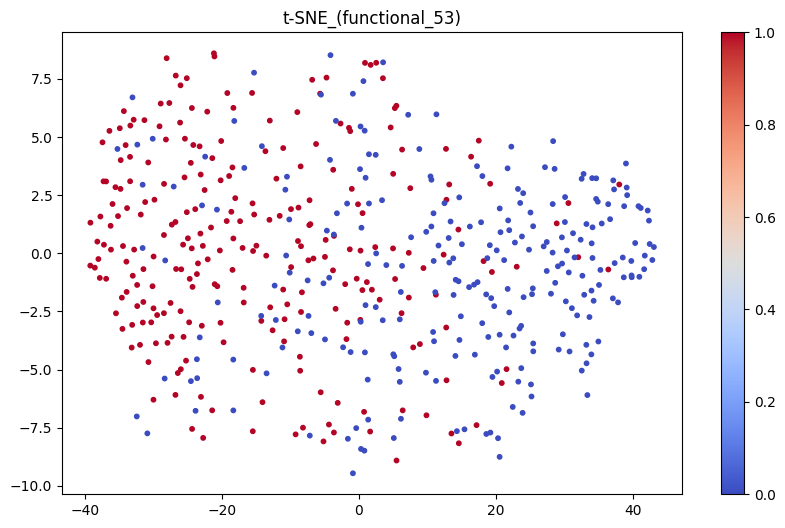

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


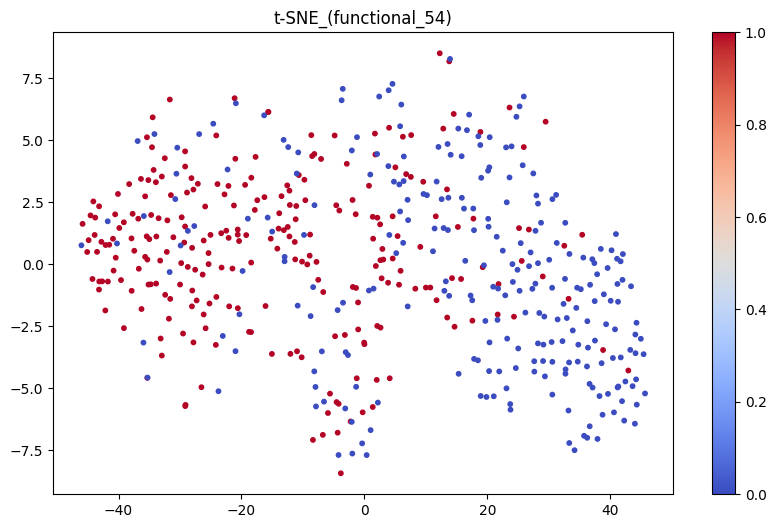

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


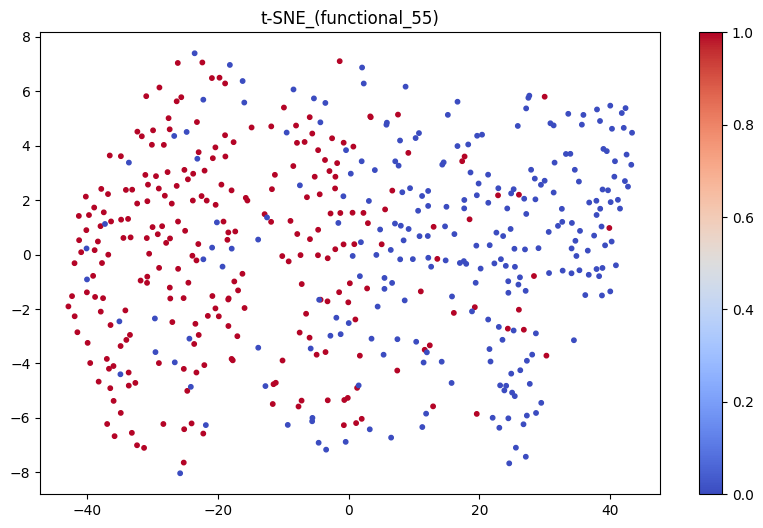

In [51]:
# Define a function to extract features from the penultimate layer
from keras.models import Model

def get_penultimate_layer_output(model, input_data):
    # Get the output of the second-to-last layer (penultimate)
    penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    return penultimate_layer_model.predict(input_data)

models = [ simple_model, inception_model, res_model]
# Extract features from the penultimate layer after training
for model in models:
    penultimate_output = get_penultimate_layer_output(model, [X_test_num, X_test_embeddings])

    # Plot t-SNE for the penultimate layer features
    plot_tsne(penultimate_output, y_test, f't-SNE_({model.name})')


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


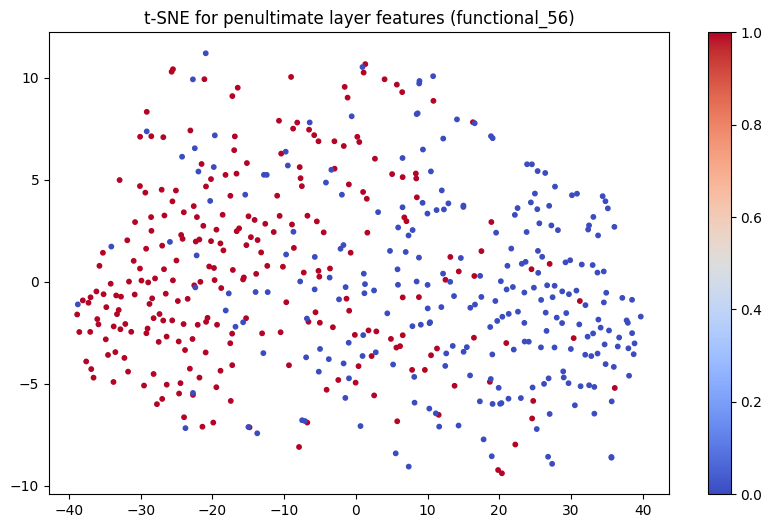

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


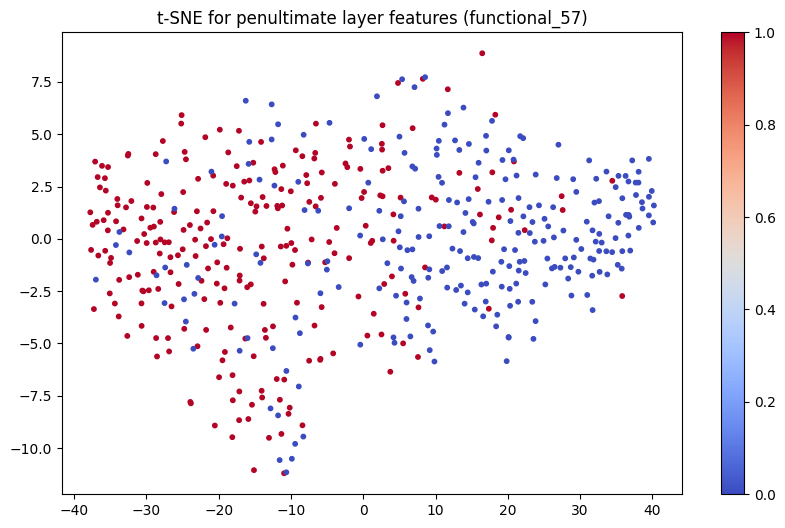

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


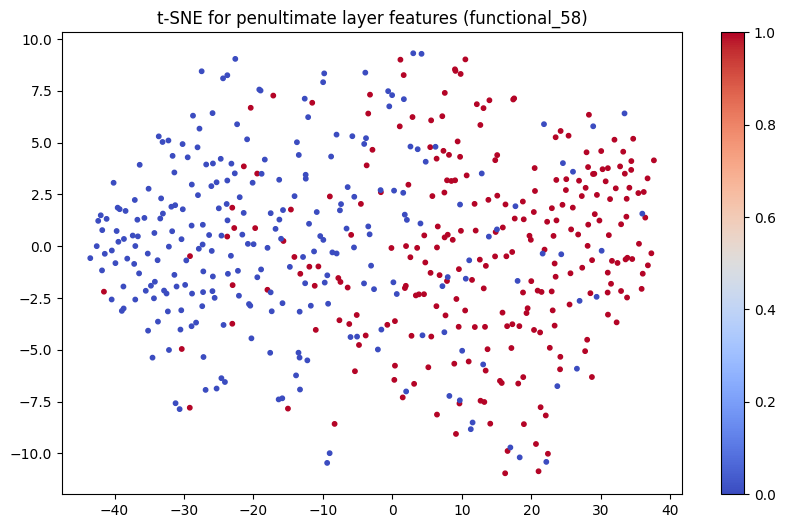

In [52]:
pssm_models = [simple_pssm_model, inception_pssm_model, res_pssm_model]

# Extract features from the penultimate layer after training
for model in pssm_models:
    penultimate_output = get_penultimate_layer_output(model, [X_test_num, X_test_embeddings, X_test_PSSM])

    # Plot t-SNE for the penultimate layer features 
    plot_tsne(penultimate_output, y_test, f't-SNE for penultimate layer features ({model.name})')

In [75]:
#20 randonly balanced test set
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')
test_pos = test[test['label'] == 1]
test_neg = test[test['label'] == 0]

accuracies = []
mccs = []
aucs = []
auprcs = []
precisions = []
recalls = []
specificities = []
f1s = []

accuracies_pssm = []
mccs_pssm = []
aucs_pssm = []
auprcs_pssm = []
precisions_pssm = []
recalls_pssm = []
specificities_pssm = []
f1s_pssm = []

# Load the models
res_model = load_model('Thesis-Results/Models/Full Models/res_model.h5')
res_pssm_model = load_model('Thesis-Results/Models/Full Models/res_pssm_model.h5')

for i in range(20):
    test_neg = test_neg.sample(n=253, random_state=np.random.randint(0, 10000))

    test= pd.concat([test_pos, test_neg], axis=0)


    X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
    X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
    X_test_PSSM = np.stack(X_test_PSSM.values)
    X_test_embeddings = np.stack(X_test_embeddings.values)
    scaler = PowerTransformer()
    X_test_PSSM = scaler.fit_transform(X_test_PSSM)
    X_test = test['sequence'].values
    y_test = test['label'].values

    # Create a dictionary to map amino acids to integers
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]
    X_test_num = np.array(X_test_num)

    # Evaluate the models
    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(res_model, X_test_num, X_test_embeddings, y_val=y_test, print_metrics=False)
    accuracies.append(acc)
    mccs.append(mcc)
    aucs.append(auc)
    auprcs.append(auprc)
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)
    f1s.append(f1)

    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(res_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_val=y_test, print_metrics=False)
    accuracies_pssm.append(acc)
    mccs_pssm.append(mcc)
    aucs_pssm.append(auc)
    auprcs_pssm.append(auprc)
    precisions_pssm.append(precision)
    recalls_pssm.append(recall)
    specificities_pssm.append(specificity)
    f1s_pssm.append(f1)

print("Results for Residual Model:")
print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
print(f'AUPRC: {np.mean(auprcs)} +- {np.std(auprcs)}')
print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')

print("Results for Residual Model with PSSM:")
print(f'Accuracy: {np.mean(accuracies_pssm)} +- {np.std(accuracies_pssm)}')
print(f'MCC: {np.mean(mccs_pssm)} +- {np.std(mccs_pssm)}')
print(f'AUC: {np.mean(aucs_pssm)} +- {np.std(aucs_pssm)}')
print(f'AUPRC: {np.mean(auprcs_pssm)} +- {np.std(auprcs_pssm)}')
print(f'Precision: {np.mean(precisions_pssm)} +- {np.std(precisions_pssm)}')
print(f'Recall: {np.mean(recalls_pssm)} +- {np.std(recalls_pssm)}')
print(f'Specificity: {np.mean(specificities_pssm)} +- {np.std(specificities_pssm)}')
print(f'F1: {np.mean(f1s_pssm)} +- {np.std(f1s_pssm)}')





    

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━